In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [ ]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

 91% 44.0M/48.1M [00:01<00:00, 31.9MB/s]
100% 48.1M/48.1M [00:01<00:00, 25.6MB/s]


In [ ]:
!unzip sign-language-for-numbers.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sign Language for Numbers/7/seven_549.jpg  
  inflating: Sign Language for Numbers/7/seven_55.jpg  
  inflating: Sign Language for Numbers/7/seven_550.jpg  
  inflating: Sign Language for Numbers/7/seven_551.jpg  
  inflating: Sign Language for Numbers/7/seven_552.jpg  
  inflating: Sign Language for Numbers/7/seven_553.jpg  
  inflating: Sign Language for Numbers/7/seven_554.jpg  
  inflating: Sign Language for Numbers/7/seven_555.jpg  
  inflating: Sign Language for Numbers/7/seven_556.jpg  
  inflating: Sign Language for Numbers/7/seven_557.jpg  
  inflating: Sign Language for Numbers/7/seven_558.jpg  
  inflating: Sign Language for Numbers/7/seven_559.jpg  
  inflating: Sign Language for Numbers/7/seven_56.jpg  
  inflating: Sign Language for Numbers/7/seven_560.jpg  
  inflating: Sign Language for Numbers/7/seven_561.jpg  
  inflating: Sign Language for Numbers/7/seven_562.jpg  
  inflating: Sign Language for Numbers/

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [ ]:
data_directory = "/content/Sign Language for Numbers"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torchvision as torchvision
model = torchvision.models.mobilenet_v3_small(pretrained=False).to(device)
model.fc = nn.Linear(model.classifier[0].in_features, 11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(validation_loader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_loader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/181], Loss: 2.198634624481201
Epoch [1/10], Step [100/181], Loss: 1.8788734674453735
Epoch [1/10], Step [150/181], Loss: 1.6101592779159546
Epoch [1/10], Training Loss: 2.056018323529491, Training Accuracy: 0.3329870104789734, Validation Loss: 2.758517778836764, Validation Accuracy: 0.09090909361839294
Epoch [2/10], Step [50/181], Loss: 1.1516242027282715
Epoch [2/10], Step [100/181], Loss: 0.9447490572929382
Epoch [2/10], Step [150/181], Loss: 0.7999287843704224
Epoch [2/10], Training Loss: 1.0461589679204297, Training Accuracy: 0.6414718627929688, Validation Loss: 6.516122462371221, Validation Accuracy: 0.09090909361839294
Epoch [3/10], Step [50/181], Loss: 0.560332715511322
Epoch [3/10], Step [100/181], Loss: 0.554205596446991
Epoch [3/10], Step [150/181], Loss: 0.7289043068885803
Epoch [3/10], Training Loss: 0.5930632925823908, Training Accuracy: 0.8069263696670532, Validation Loss: 2.504940091417386, Validation Accuracy: 0.4763636291027069
Epoch [4/10], Step

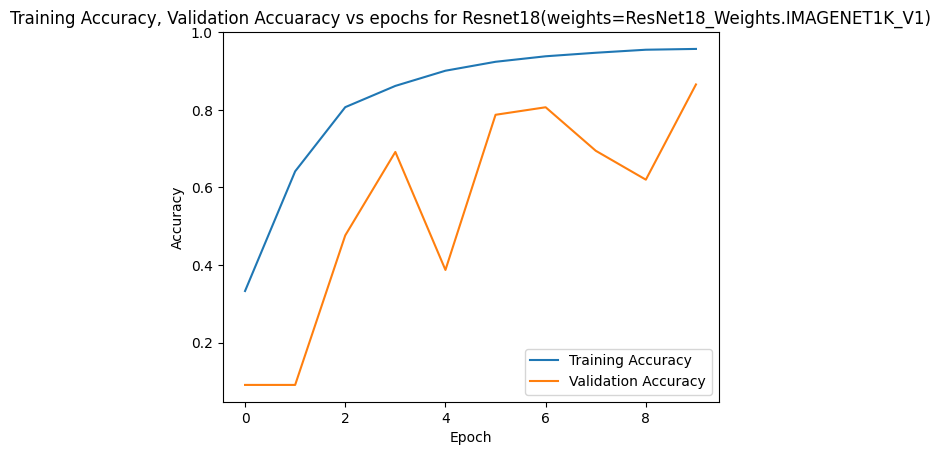

In [ ]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuracy vs epochs for MobileNetV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Accuracy: 0.8824242424242424


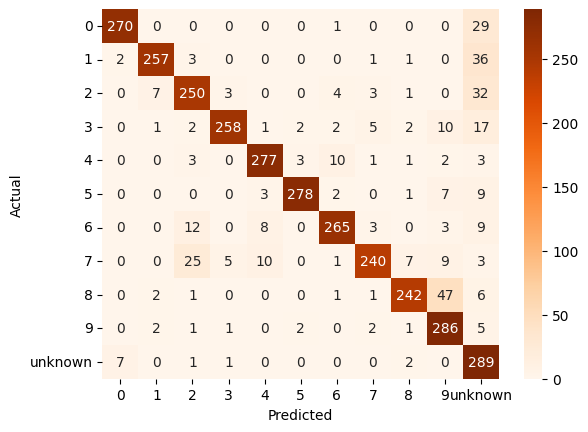

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       300
           1       0.96      0.86      0.90       300
           2       0.84      0.83      0.84       300
           3       0.96      0.86      0.91       300
           4       0.93      0.92      0.92       300
           5       0.98      0.93      0.95       300
           6       0.93      0.88      0.90       300
           7       0.94      0.80      0.86       300
           8       0.94      0.81      0.87       300
           9       0.79      0.95      0.86       300
     unknown       0.66      0.96      0.78       300

    accuracy                           0.88      3300
   macro avg       0.90      0.88      0.89      3300
weighted avg       0.90      0.88      0.89      3300



In [ ]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

target_names = list(train_dataset.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.003s...
[t-SNE] Computed neighbors for 11550 samples in 6.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 1.185155
[t-SNE] KL divergence

<ipython-input-18-47d71a04a03e>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names)-1)
<ipython-input-18-47d71a04a03e>:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))


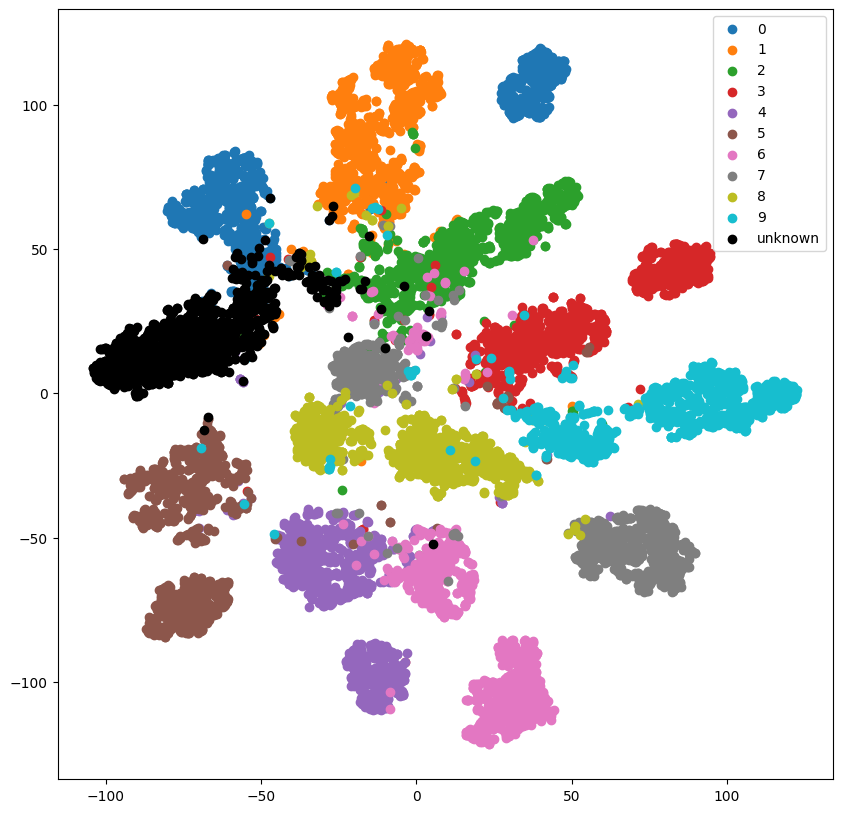

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.to('cuda')


model = torch.nn.Sequential(*(list(model.children())[:-1]))


model.eval()

features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)


u = labels == target_names.index("unknown")

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()


